In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

In [2]:
sessions = pd.read_csv (r'/Users/annakostrova/Downloads/sessions.csv')
users = pd.read_csv (r'/Users/annakostrova/Downloads/users.csv')
payments = pd.read_csv (r'/Users/annakostrova/Downloads/payments.csv')

sessions['event_time'] = pd.to_datetime(sessions['event_time'])
users['install_date'] = pd.to_datetime(users['install_date'])
payments['event_time'] = pd.to_datetime(payments['event_time'])

In [3]:
# Минимальное время для каждого в 0 день == самая первая сессия
sessions0day = sessions[sessions['event_time'].dt.date.astype(str) == '2022-07-01'].groupby(['user_id']).agg(Minimum_Date=('event_time', np.min))
sessions0day.rename(columns = {'Minimum_Date':'event_time0'}, inplace = True)

# Отсчет 1 дня для каждого 
sessions0day['event_time24'] = sessions0day['event_time0'] + timedelta(hours=24)
sessions0day['event_time48'] = sessions0day['event_time0'] + timedelta(hours=24*2)

# Отсчет 7 дня для каждого 
sessions0day['event_time6'] = sessions0day['event_time0'] + timedelta(hours=24*6)
sessions0day['event_time7'] = sessions0day['event_time0'] + timedelta(hours=24*7)

In [5]:
# Те, кто заходил первого июля + границы времени 24 и 48
df = pd.merge(sessions, sessions0day, on='user_id', how='left').dropna(thresh=3)

df1 = df[df["event_time"] >= df["event_time24"]]
df1 = df1[df1["event_time"] <= df1["event_time48"]]

# кол-во пользователей уникальных, зашедших в течение 24 и 48 часов/кол-во уникальных в 0 день
"{:,.2f}%".format(round(df1.user_id.nunique()/sessions[sessions['event_time'].dt.date.astype(str) == '2022-07-01'].user_id.nunique(),4)*100)

'20.58%'

In [6]:
# Те, кто заходил первого июля + границы времени для 7 дня
df1 = df[df["event_time"] >= df["event_time6"]]
df1 = df1[df1["event_time"] <= df1["event_time7"]]

# кол-во пользоватеелей уникальных, зашедших в течение 7 дня/кол-во уникальных в 0 день

"{:,.2f}%".format(round(df1.user_id.nunique()/sessions[sessions['event_time'].dt.date.astype(str) == '2022-07-01'].user_id.nunique(),4)*100)
                  

'4.18%'

In [7]:
# ARPU
# сумма денег общая с 01.07.2022 по 14.07.2022 / уникальные ID за весь период

paymentsARPU = payments[payments.event_time.between('2022-07-01','2022-07-14')]
"${:,.2f}".format(round(paymentsARPU['price_usd'].sum()/users[users.install_date.between('2022-07-01','2022-07-14')].user_id.nunique(),2))


'$0.16'

In [8]:
# ARPPU
# сумма денег общая с 01.07.2022 по 14.07.2022 / уникальные платящие ID за весь период

paymentsARPPU = payments[payments.event_time.between('2022-07-01','2022-07-14')]
"${:,.2f}".format(round(paymentsARPPU['price_usd'].sum()/paymentsARPPU.user_id.nunique(),2))

'$11.64'

In [9]:
# График полученного дохода по уровню игроков, в период с 01-07-2022 до 14-07-2022
payments = payments[payments.event_time.between('2022-07-01','2022-07-14')]

# Группирую по уровням, чтобы найти сумму, заработанную с игроков
plot = payments.groupby(['user_level']).sum()
plot = plot.rename_axis('user_level').reset_index()
plot['user_level_cat'] = plot['user_level'].astype('str').astype('category')

# Группирую по уровням, чтобы найти кол-во игроков, совершивших покупку на каком-то из уровней
plot2 = payments
plot2 = plot2.groupby(['user_level']).count()
plot2 = plot2.rename_axis('user_level').reset_index()
plot2['user_level_cat'] = plot2['user_level'].astype('str').astype('category')
plot2

Text(0, 0.5, 'Кол-во игроков, совершивших покупку')

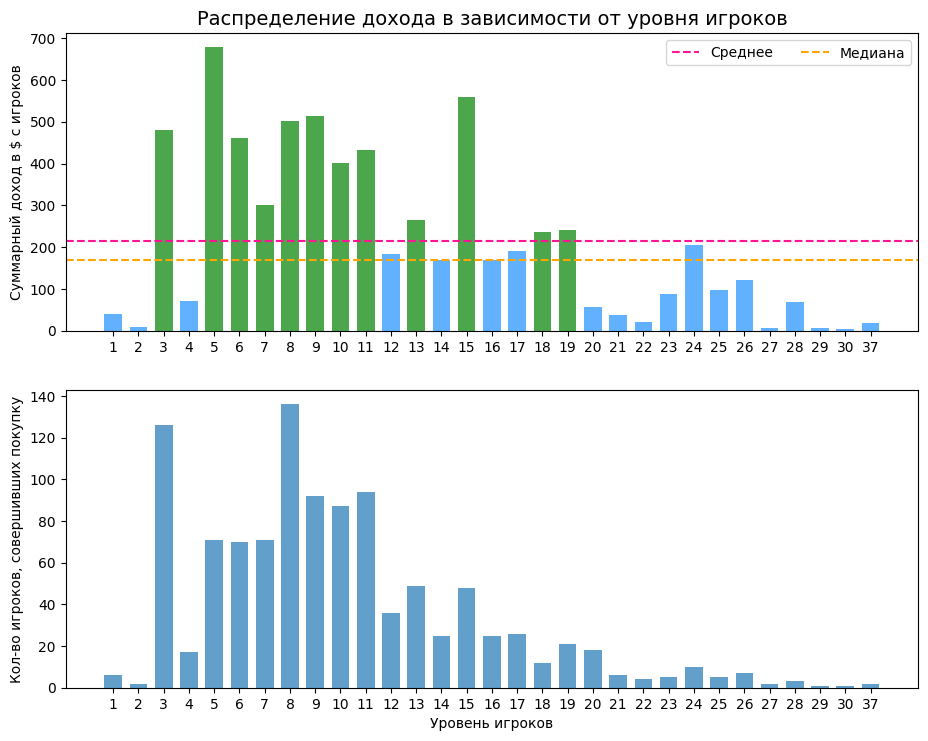

In [10]:
plt.rcParams["figure.figsize"] = [11.00, 8.50]
fig, (ax1, ax2) = plt.subplots(2)

colors = np.where(plot.price_usd < np.nanmean(plot.price_usd), 'dodgerblue', 'g')
ax1.bar(x = plot.user_level_cat, height = plot.price_usd, width = 0.7, color=colors, alpha=.7)
ax1.set_title('Распределение дохода в зависимости от уровня игроков', fontsize=14)
ax1.set_xlabel('')
ax1.set_ylabel('Суммарный доход в $ с игроков')
ax1.axhline(y=np.nanmean(plot.price_usd), color='deeppink', linestyle='--', linewidth=1.5, label='Среднее')
ax1.axhline(y=np.nanmedian(plot.price_usd), color='orange', linestyle='--', linewidth=1.5, label='Медиана')
ax1.legend(fontsize=10, ncol=4)

ax2.bar(x = plot2.user_level_cat, height = plot2.user_id, width = 0.7, alpha=.7)
# ax2.set_title('Кол-во игроков, совершивших покупку на конкретном уровне', fontsize=14)
ax2.set_xlabel('Уровень игроков')
ax2.set_ylabel('Кол-во игроков, совершивших покупку')

Text(0, 0.5, 'Суммарный доход в $ с игроков')

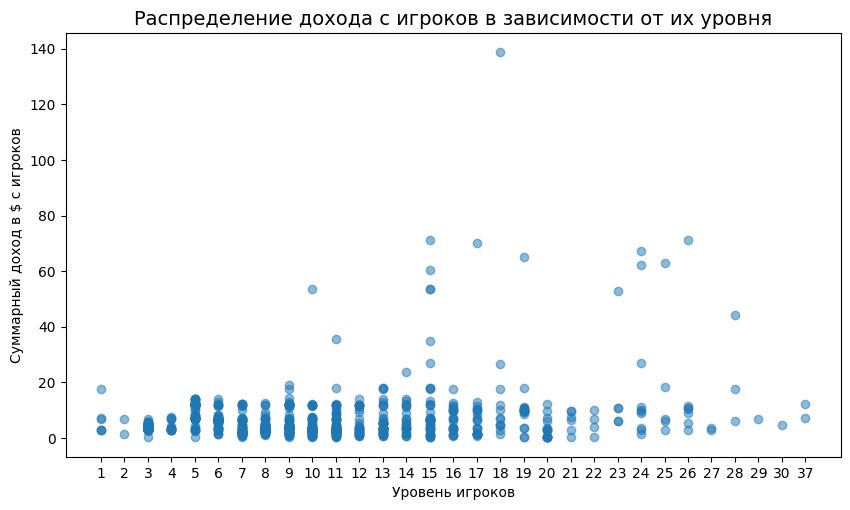

In [14]:
# Сохраняю график
# fig.savefig(r'/Users/annakostrova/Downloads/plot.png')

In [ ]:
# Scatterplot
payments = payments.sort_values('user_level')
payments['user_level_cat'] = payments['user_level'].astype('str').astype('category')

plt.rcParams["figure.figsize"] = [10.00, 5.50]

plt.scatter(payments.user_level_cat, payments.price_usd, alpha=.5)
plt.title('Распределение дохода с игроков в зависимости от их уровня', fontsize=14)
plt.xlabel('Уровень игроков')
plt.ylabel('Суммарный доход в $ с игроков')